<a href="https://colab.research.google.com/github/JoannaLe/cancer-detection/blob/master/091_zoom_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download OpenSlide that reads whole-slide images
!apt-get install openslide-tools
!pip install openslide-python

# Import dependencies 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import os

# Download an example slide (not yet the input x) and a tumor mask (y)
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url
  
# Read a patch from the slide
# Returns a RGB array
def read_slide(slide, x, y, level, width, height, as_float=False):
    # read_region() API call 
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
# Use Open Slides to read the slide and mask
slide = open_slide(slide_path)
# Print the dimensions of the slide 
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s with width: %d, height: %d" % (tumor_mask_path,
                                                               tumor_mask.level_dimensions[0][0], 
                                                               tumor_mask.level_dimensions[0][1]))


# Look into the slide at different zoom levels 
print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [3]:
# Open Google Cloud Drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
patch_x_dim = 224 #
patch_y_dim = 224 #

def create_patches(level, img, slide, tumor_mask):
  downsample = 2 ** level
  num_patch_x = slide.level_dimensions[level][0] // (patch_x_dim // 2) 
  num_patch_y = slide.level_dimensions[level][1] // (patch_y_dim // 2)
  print(num_patch_x, num_patch_y)

  slides = []
  for i in range(0, num_patch_y + 1): # rows
    for j in range(0, num_patch_x + 1): # columns 
      width2 = patch_x_dim
      height2 = patch_y_dim
      need_padding = False # default 

      if j is num_patch_x: # edge of the row 
        width2 = slide.level_dimensions[level][0] % (patch_x_dim // 2)
        need_padding = True

      if i is num_patch_y:
        height2 = slide.level_dimensions[level][1] % (patch_x_dim // 2)
        need_padding = True

      slide_image = read_slide(slide, 
                               x=(0 + j * (patch_x_dim // 2)) * downsample,
                               y=(0 + i * (patch_x_dim // 2)) * downsample, 
                               level=level, 
                               width=width2, 
                               height=height2) # edge cases 

  #     Post-processing, edge cases   
      if i is num_patch_y or j is num_patch_x:
        temp_array = np.full((patch_x_dim, patch_y_dim, 3), -1) # fill with -1's 
  #       print(temp_array[50, 50, :])
  #       print(slide_image.shape)
        for j in range(slide_image.shape[0]): # do not repeat indices 
          for k in range(slide_image.shape[1]):
            for l in range(slide_image.shape[2]):
              temp_array[j, k, l] = slide_image[j, k, l]

        slide_image = temp_array
  #       print(slide_image[50, 50, :])
  #       print(slide_image[280, 280, :]) # -1's

      slides.append(slide_image)


  # Add to local gdrive  
  # img = "091"
  patch_dir = "gdrive/My Drive/cancer-detection/patch-zoom-" + str(level)
  print(patch_dir)
  for i in range(len(slides)):
    patch_name = img + "-patch-" + str(i) + ".npy"
    print(patch_name)
    data = slides[i]
#     print(data)
    np.save(patch_name, data)
    !mv "$patch_name" "$patch_dir"


  masks = []
  matrix = np.zeros((num_patch_y + 1, num_patch_x + 1), dtype=int)
  print(matrix.shape)
  # for every row 
  for i in range(0, num_patch_y + 1):
    # span every cell 
    for j in range(0, num_patch_x + 1):
      width2 = patch_x_dim
      height2 = patch_y_dim
      checkin = False
      if i is num_patch_y:
        checkin = True
        width2 = slide.level_dimensions[level][0] % (patch_x_dim // 2)
      if j is num_patch_x:
        height2 = slide.level_dimensions[level][1] % (patch_x_dim // 2)
        checkin = True


      mask_image = read_slide(tumor_mask, 
                               x=(0 + j * (patch_x_dim // 2)) * downsample, # 128 = downsample factor
                               y=(0 + i * (patch_x_dim // 2)) * downsample, 
                               level=level, 
                               width=width2, # edge 
                               height=height2) 
      mask_image = mask_image[:,:,0] # RGB => 
  #     if checkin
  #       print(mask_image.shape) # debug: should be not 300, 300

      # count tumors in the patch
      count = 0 
      # every row 
      for row in mask_image: 
        for cell in row:
          if int(cell) == 1:
            count += 1
      perc = count / (patch_x_dim * patch_y_dim) # percentage wise
  #     print(perc)
      if perc > 0.1:
        masks.append(1)
        matrix[i][j] = 1
      else:
        masks.append(0)
        matrix[i][j] = 0

  plt.figure(figsize=(5,5), dpi=100)
  plt.imshow(matrix)

  # Add to local gdrive
  mask_dir = "gdrive/My Drive/cancer-detection/mask-zoom-" + str(level)
  print(mask_dir)
  for i in range(len(masks)):
    mask_name = img + "-mask-" + str(i)
    with open(mask_name, 'w') as file:
      data = masks[i]
      file.write(str(data))

    !mv "$mask_name" "$mask_dir"

In [0]:
patch_x_dim = 224 # 
patch_y_dim = 224 #

def create_patches_validation(level, img, slide, tumor_mask):
  downsample = 2 ** level
  num_patch_x = slide.level_dimensions[level][0] // (patch_x_dim // 2) 
  num_patch_y = slide.level_dimensions[level][1] // (patch_y_dim // 2)
  print(num_patch_x, num_patch_y) 


  slides = []
  for i in range(0, num_patch_y + 1): # rows
    for j in range(0, num_patch_x + 1): # columns 
      width2 = patch_x_dim
      height2 = patch_y_dim
      need_padding = False # default 

      if j is num_patch_x: # edge of the row 
        width2 = slide.level_dimensions[level][0] % (patch_x_dim // 2) # 300 / 2
        need_padding = True

      if i is num_patch_y:
        height2 = slide.level_dimensions[level][1] % (patch_x_dim // 2)
        need_padding = True

      slide_image = read_slide(slide, 
                               x=(0 + j * (patch_x_dim // 2)) * downsample,
                               y=(0 + i * (patch_x_dim // 2)) * downsample, 
                               level=level, 
                               width=width2, 
                               height=height2) # edge cases 

  #     Post-processing, edge cases   
      if i is num_patch_y or j is num_patch_x:
        temp_array = np.full((patch_x_dim, patch_y_dim, 3), -1) # fill with -1's 
  #       print(temp_array[50, 50, :])
  #       print(slide_image.shape)
        for j in range(slide_image.shape[0]): # do not repeat indices 
          for k in range(slide_image.shape[1]):
            for l in range(slide_image.shape[2]):
              temp_array[j, k, l] = slide_image[j, k, l]

        slide_image = temp_array
      slides.append(slide_image)

  # Add to local gdrive
  patch_dir = "gdrive/My Drive/cancer-detection/patch-val" + str(level) + "/" + img
  print(patch_dir)
  for i in range(len(slides)):
    patch_name = img + "-patch-" + str(i) + ".npy"
    print(patch_name)
    data = slides[i]
#     print(data)
    np.save(patch_name, data)
    !mv "$patch_name" "$patch_dir"


  masks = []
  matrix = np.zeros((num_patch_y + 1, num_patch_x + 1), dtype=int)
  print(matrix.shape)
  # for every row 
  for i in range(0, num_patch_y + 1):
    # span every cell 
    for j in range(0, num_patch_x + 1):
      width2 = patch_x_dim
      height2 = patch_y_dim
      checkin = False
      if i is num_patch_y:
        checkin = True
        width2 = slide.level_dimensions[level][0] % (patch_x_dim // 2)
      if j is num_patch_x:
        height2 = slide.level_dimensions[level][1] % (patch_x_dim // 2)
        checkin = True


      mask_image = read_slide(tumor_mask, 
                               x=(0 + j * (patch_x_dim // 2)) * downsample, # 128 = downsample factor
                               y=(0 + i * (patch_x_dim // 2)) * downsample, 
                               level=level, 
                               width=width2, # edge 
                               height=height2) 
      mask_image = mask_image[:,:,0] # RGB => 
  #     if checkin
  #       print(mask_image.shape) # debug: should be not 300, 300

      # count tumors in the patch
      count = 0 
      # every row 
      for row in mask_image: 
        for cell in row:
          if int(cell) == 1:
            count += 1
      perc = count / (patch_x_dim  * patch_x_dim) # percentage wise
  #     print(perc)
      if perc > 0.1:
        masks.append(1)
        matrix[i][j] = 1
      else:
        masks.append(0)
        matrix[i][j] = 0

  plt.figure(figsize=(5,5), dpi=100)
  plt.imshow(matrix)

  # Add to local gdrive
#   mask_dir = "gdrive/My Drive/cancer-detection/mask-zoom-" + str(level)
  mask_dir = "gdrive/My Drive/cancer-detection/mask-val" + str(level) + "/" + img
  print(mask_dir)
  for i in range(len(masks)):
    mask_name = img + "-mask-" + str(i)
    with open(mask_name, 'w') as file:
      data = masks[i]
      file.write(str(data))

    !mv "$mask_name" "$mask_dir"

In [6]:
print(os.getcwd())
os.chdir('/content')
print(os.getcwd())
# os.chdir('cancer-detection_data')
!ls

/content
/content
gdrive	sample_data  tumor_091_mask.tif  tumor_091.tif


13 30
gdrive/My Drive/cancer-detection/patch-val6/016
016-patch-0.npy
016-patch-1.npy
016-patch-2.npy
016-patch-3.npy
016-patch-4.npy
016-patch-5.npy
016-patch-6.npy
016-patch-7.npy
016-patch-8.npy
016-patch-9.npy
016-patch-10.npy
016-patch-11.npy
016-patch-12.npy
016-patch-13.npy
016-patch-14.npy
016-patch-15.npy
016-patch-16.npy
016-patch-17.npy
016-patch-18.npy
016-patch-19.npy
016-patch-20.npy
016-patch-21.npy
016-patch-22.npy
016-patch-23.npy
016-patch-24.npy
016-patch-25.npy
016-patch-26.npy
016-patch-27.npy
016-patch-28.npy
016-patch-29.npy
016-patch-30.npy
016-patch-31.npy
016-patch-32.npy
016-patch-33.npy
016-patch-34.npy
016-patch-35.npy
016-patch-36.npy
016-patch-37.npy
016-patch-38.npy
016-patch-39.npy
016-patch-40.npy
016-patch-41.npy
016-patch-42.npy
016-patch-43.npy
016-patch-44.npy
016-patch-45.npy
016-patch-46.npy
016-patch-47.npy
016-patch-48.npy
016-patch-49.npy
016-patch-50.npy
016-patch-51.npy
016-patch-52.npy
016-patch-53.npy
016-patch-54.npy
016-patch-55.npy
016-

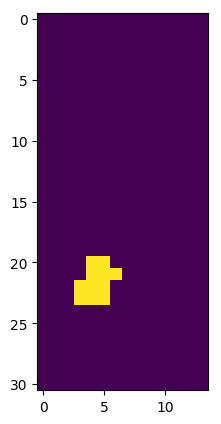

In [16]:
imgs = ['005', '091']
val_imgs = ['016']
level = 6

for img in imgs:
  # Download an example slide (not yet the input x) and a tumor mask (y)
  slide_path = 'tumor_'+ img +'.tif'
  mask_path = 'tumor_'+ img +'_mask.tif'

  slide_url = 'gdrive/My Drive/cancer-detection/slides/' + slide_path
  mask_url = 'gdrive/My Drive/cancer-detection/slides/' + mask_path

  slide = open_slide(slide_url)
  tumor_mask = open_slide(mask_url)
  
  create_patches(level, img, slide, tumor_mask)

for img in val_imgs:
  # Download an example slide (not yet the input x) and a tumor mask (y)
  slide_path = 'tumor_'+ img +'.tif'
  mask_path = 'tumor_'+ img +'_mask.tif'

  slide_url = 'gdrive/My Drive/cancer-detection/slides/' + slide_path
  mask_url = 'gdrive/My Drive/cancer-detection/slides/' + mask_path

  slide = open_slide(slide_url)
  tumor_mask = open_slide(mask_url)
  
  create_patches_validation(level, img, slide, tumor_mask)